### Based on Mask-RCNN Keypoint model ([code](https://github.com/FangYang970206/MaskRCNN-Keypoint-Demo)) with demo [notebook](https://colab.research.google.com/github/FangYang970206/MaskRCNN-Keypoint-Demo/blob/master/demo.ipynb)
Code is based on Tensorflow 1.0 and older dependent libraries

### Install pre-requisite libraries (using older TF and Keras)

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
import keras
print(keras.__version__)

2.1.6


Using TensorFlow backend.


In [ ]:
# Restart runtime after all packages are installed

!pip install imgaug==0.2.5
!pip install folium==0.2.1
!pip install -q pillow
!pip install -q h5py
!pip install opencv-python
!pip install -U scikit-image
!pip install -U cython
!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"
!pip install keras==2.1.6 --force-reinstall
!pip install six==1.12.0
!pip install scipy==1.1.0

### Download Mask-RCNN with Pose Estimation code and pre-trained model

In [ ]:
!git clone https://github.com/FangYang970206/MaskRCNN-Keypoint-Demo

In [3]:
cd MaskRCNN-Keypoint-Demo

/content/MaskRCNN-Keypoint-Demo


In [ ]:
!wget https://www.dropbox.com/s/5ctrg3br94srrx9/mask_rcnn_coco.h5

In [4]:
!ls

coco.py     config.py	gif	 mask_rcnn_coco.h5  model.py   utils.py
colors.txt  demo.ipynb	main.py  media		    README.md


### Video processing utilities (Do not modify)

In [9]:
import cv2

#----------------------------------------------------
# Video Download and Display utility
#----------------------------------------------------
class ShowVid():
  def __init__(self, video_file=None):
    self.youtube_id = None
    self.video_file = video_file

  #----------------------------------------------------
  # Get stats on a Youtube video
  #----------------------------------------------------
  def _youtube_info(self, youtube):
    # get video information
    print (f'ID: {youtube.video_id}, Title: {youtube.title}, Length: {youtube.length}\n')

    # Get video stream formats
    stream = youtube.streams.all()
    print ('Streams:\n')
    for i in stream:
      print(i)

    # Thumbnail image URL
    return youtube.thumbnail_url

  #----------------------------------------------------
  # Download a video from Youtube to a local file using Pytube library
  #----------------------------------------------------
  def youtube_download(self, video_id, download_dir, video_stem):
    # Install pytube
    !pip install pytube3
    import pytube

    # Get Pytube's youtube object for the video
    video_url = f'https://www.youtube.com/watch?v={video_id}'
    youtube = pytube.YouTube(video_url)
    
    # Show some stats about the video
    self._youtube_info(youtube)

    # Choose the first stream format (format contains mime_type, resolution, fps, vcodec, acodec)
    video = youtube.streams.first()

    # Download the video
    self.video_file = video.download(download_dir, video_stem)
    self.youtube_id = video_id

    return self.video_file

  #----------------------------------------------------
  # Extract just the first few 'duration' seconds of a video
  #----------------------------------------------------
  def extract_short(self, short_file, duration):
    assert (self.video_file is not None)
    !ffmpeg -y -loglevel info -i {self.video_file} -t {duration} {short_file}
    self.video_file = short_file

  #----------------------------------------------------
  # Display a locally downloaded video file
  #----------------------------------------------------
  def show_mp4(self, width=640, height=480):
    import io
    import base64
    from IPython.display import HTML

    assert (self.video_file is not None)
    video_file = self.video_file

    video_encoded = base64.b64encode(io.open(video_file, 'rb').read())
    return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                          <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                        </video>'''.format(width, height, video_encoded.decode('ascii')))
    
  #----------------------------------------------------
  # Display a video on Youtube
  #----------------------------------------------------
  def show_youtube_video(self, youtube_id):
    from IPython.display import YouTubeVideo
    YouTubeVideo(youtube_id)

  #----------------------------------------------------
  # Read a video frame-by-frame and call a callback function to process
  # each frame. Stop when we have completed the given number of frames.
  # Write an output video file if required.
  #----------------------------------------------------
  def process_video(self, process_cb, num_frames, vid_out_name=None):
    assert (self.video_file is not None)
    video_file = self.video_file

    i_frames = 0
    vid = cv2.VideoCapture(str(video_file))

    # Get video width, height and frames per second
    width, height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    print (f'Video size {width}x{height} at {fps} fps')

    if (vid_out_name is not None):
      # Write an AVI file and convert to MP4 later
      vid_out_avi = f'{vid_out_name}.avi'
      vid_out = cv2.VideoWriter(vid_out_avi, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

    while(vid.isOpened()):
      ret, frame = vid.read()

      # Bail out when the video file ends
      if not ret:
        break

      frame_out = process_cb(frame)

      if (vid_out_name is not None):
        vid_out.write(frame_out)

      i_frames += 1
      if (i_frames > num_frames):
        vid.release()
        if (vid_out_name is not None):
          vid_out.release()
          # convert AVI to MP4
          vid_out_mp4 = f'{vid_out_name}.mp4'
          !ffmpeg -y -loglevel info -i {vid_out_avi} {vid_out_mp4}
        break

### Load example image

In [5]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

def load(name):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    image = cv.imread(name)
    # convert to BGR format
    image = np.array(image)
    return image
  
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

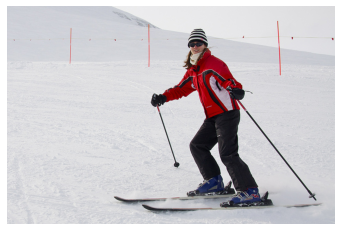

In [6]:
image = load("media/ski.jpg")
imshow(image)

### Load example video

In [10]:
sv_tr = ShowVid('media/human.mp4')
sv_tr.show_mp4(width=480, height=360)

Output hidden; open in https://colab.research.google.com to view.

### Run Pose Estimation inference

In [11]:
import IPython.core.debugger as db
import os
import sys
import random
import argparse
import numpy as np
import cv2 as cv

import coco
import utils
import model as modellib

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7

def run_predict(image=None, video=None):
    # Root directory of the project
    ROOT_DIR = os.getcwd()

    # Directory to save logs and trained model
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")

    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        raise AssertionError('please download the pre-trained model')

    inference_config = InferenceConfig()

    # Create model object in inference mode.
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=inference_config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)

    # Directory of images to run detection on
    #COCO_DIR = "images"  # TODO: enter value here
    #IMAGE_DIR = os.path.join(ROOT_DIR, "picture")

    if (image):
        if not os.path.isfile(image):
            print("Input image file ", image, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(image)
        outputFile = image[:-4]+'_mask_rcnn_out_py.jpg'
    elif (video):
        if not os.path.isfile(video):
            print("Input video file ", video, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(video)
        video_name = video[:-4]
        vid_out_name = f'{video_name}_mask_rcnn_out_py'
        vid_out_avi = f'{vid_out_name}.avi'
        outputFile = video[:-4]+'_mask_rcnn_out_py.avi'
    else:
        cap = cv.VideoCapture(0)

    if (video):
        vid_writer = cv.VideoWriter(outputFile,
                                    cv.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                    30,
                                    (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
                                     round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

    i_frames = 0
    num_frames = 140
    while (cap.isOpened()):
        hasFrame, frame = cap.read()
        if not hasFrame:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
            #cv.waitKey(3000)
            break
        
        print("frame shape:", frame.shape)
        # class_names = ['BG', 'person']
        results = model.detect_keypoint([frame], verbose=1)
        r = results[0]
        if r['masks'].shape[0]:
          frame = display_keypoints(frame, r)

        if (image):
          cv.imwrite(outputFile, frame.astype(np.uint8))
        else:
          vid_writer.write(frame.astype(np.uint8))


        i_frames += 1
        if (i_frames > num_frames):
          cap.release()
          if (vid_out_name is not None):
            vid_writer.release()
            # convert AVI to MP4
            vid_out_mp4 = f'{vid_out_name}.mp4'
            !ffmpeg -y -loglevel info -i {vid_out_avi} {vid_out_mp4}
          break

def color_array():
    colorsFile = "colors.txt"
    with open(colorsFile, 'rt') as f:
        colorsStr = f.read().rstrip('\n').split('\n')
    colors = []
    for i in range(len(colorsStr)):
        rgb = colorsStr[i].split(' ')
        color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
        colors.append(color)
    return colors

def display_keypoints(frame, r):
            colors = color_array()
            maskThreshold = 0.3

            for i in range(r['masks'].shape[2]):
                mask = r['masks'][:, :, i]
                mask = (mask > maskThreshold)
                roi = frame[mask]
                colorIndex = random.randint(0, len(colors)-1)
                color = colors[colorIndex]
                frame[mask] = ([0.3 * color[0],
                                0.3 * color[1],
                                0.3 * color[2]] + 0.7 * roi).astype(np.uint8)
                mask = mask.astype(np.uint8)
                contours, hierarchy = cv.findContours(mask,
                                                         cv.RETR_TREE,
                                                         cv.CHAIN_APPROX_SIMPLE)
                cv.drawContours(frame, contours, -1, color, 3,
                                cv.LINE_8, hierarchy, 100)
            keypoints = np.array(r['keypoints']).astype(int)
            skeleton = [0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9,
                        8, 10, 11, 13, 12, 14, 13, 15, 14, 16]
            for i in range(len(keypoints)):
                # Skeleton: 11*2
                limb_colors = [[0, 0, 255], [0, 170, 255], [0, 255, 170],
                               [0, 255, 0], [170, 255, 0], [255, 170, 0],
                               [255, 0, 0], [255, 0, 170], [170, 0, 255],
                               [170, 170, 0], [170, 0, 170]]
                if(len(skeleton)):
                    skeleton = np.reshape(skeleton, (-1, 2))
                    neck = np.array((keypoints[i, 5, :]
                                    + keypoints[i, 6, :]) / 2).astype(int)
                    if(keypoints[i, 5, 2] == 0 or keypoints[i, 6, 2] == 0):
                        neck = [0, 0, 0]
                    limb_index = -1
                    for limb in skeleton:
                        limb_index += 1
                        start_index, end_index = limb
                        if(start_index == -1):
                            Joint_start = neck
                        else:
                            Joint_start = keypoints[i][start_index]
                        if(end_index == -1):
                            Joint_end = neck
                        else:
                            Joint_end = keypoints[i][end_index]
                        if ((Joint_start[2] != 0) & (Joint_end[2] != 0)):
                            cv.line(frame,
                                    tuple(Joint_start[:2]),
                                    tuple(Joint_end[:2]),
                                    limb_colors[limb_index], 5)
                            
            return frame

In [ ]:
print(cv.__version__)
print(scipy.__version__)

4.1.2
1.5.2








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.







frame shape: (425, 640, 3)
Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
rpn_bbox                 shape: (1, 261888, 4)        min:  -11.40567  max:  104.63513
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
mrcnn_class              shape: (1, 1000, 2)          min:  

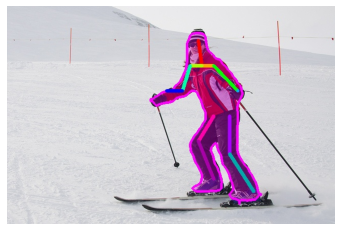

In [12]:
run_predict(image='media/ski.jpg')
image_out = load("media/ski_mask_rcnn_out_py.jpg")
imshow(image_out)

In [ ]:
run_predict(video='media/human.mp4')

In [14]:
sv_tr = ShowVid('media/human_mask_rcnn_out_py.mp4')
sv_tr.show_mp4(width=480, height=360)

Output hidden; open in https://colab.research.google.com to view.